# Ch6 Linear Model Selection and Regularization

In [58]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
import numpy as np
import statsmodels.api as sm

In [126]:
#load credit card dataset
credit = pd.read_csv('Dataset/Credit.csv', index_col =0)
credit.head()
credit.Ethnicity.value_counts()

Caucasian           199
Asian               102
African American     99
Name: Ethnicity, dtype: int64

In [128]:
credit_dummies = pd.get_dummies(credit[['Gender', 'Student', 'Married', 'Ethnicity']])
credit =credit.drop(credit[['Gender', 'Student', 'Married', 'Ethnicity']],axis=1)
credit_dummies =credit_dummies.drop(['Gender_Female', 'Student_No', 'Married_No', 'Ethnicity_African American'],axis=1)
credit_df= pd.concat([credit, credit_dummies], axis=1)
credit_df.head()
X= credit_df[['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Gender_Male', 'Student_Yes', 'Married_Yes', 'Ethnicity_Asian', 'Ethnicity_Caucasian']]
y= credit_df.Balance


,Income,Limit,Rating,Cards,Age,Education,Balance,Gender_Male,Student_Yes,Married_Yes,Ethnicity_Asian,Ethnicity_Caucasian
1,14.891,3606,283,2,34,11,333,1,0,1,0,1
2,106.025,6645,483,3,82,15,903,0,1,1,1,0
3,104.593,7075,514,4,71,11,580,1,0,0,1,0
4,148.924,9504,681,3,36,11,964,0,0,0,1,0
5,55.882,4897,357,2,68,16,331,1,0,1,0,1


## Best Subset Selection

In [137]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def fit_ols(X,y):
    ols = LinearRegression()
    ols_model =ols.fit(X,y)
    RSS= round(mean_squared_error(y,ols_model.predict(X)) * len(y),2)
    R_square = round(ols_model.score(X,y),2)
    return RSS, R_square

In [138]:
fit_ols(X,y)

(24200699.55, 0.55)

In [146]:
import itertools
from tqdm import tnrange, tqdm_notebook
k = 11
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

#Looping over k = 1 to k = 11 features in X
for k in range(1,len(X.columns) + 1):
    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X.columns,k):
        tmp_result = fit_ols(X[list(combo)],y)   #Store temp result b
        RSS_list.append(tmp_result[0])                  #Append lists
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

In [154]:
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)

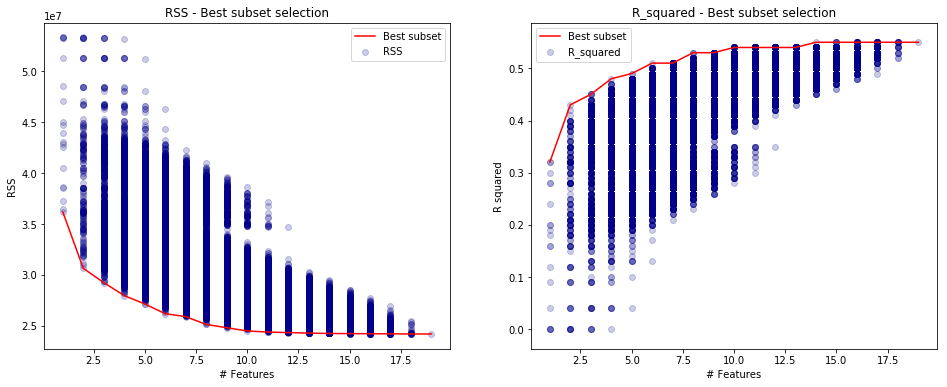

In [155]:
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(df.numb_features,df.RSS, alpha = .2, color = 'darkblue' )
ax.set_xlabel('# Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.plot(df.numb_features,df.min_RSS,color = 'r', label = 'Best subset')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(df.numb_features,df.R_squared, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

plt.show()

## Ridge Regression

In [59]:
#load Hitters Dataset
df= pd.read_csv('Dataset/Hitters.csv').dropna()

In [60]:
df.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N
5,-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,...,501,336,194,A,W,282,421,25,750.0,A


In [61]:
df.describe()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
count,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000
mean,403.642586,107.828897,11.619772,54.745247,51.486692,41.114068,7.311787,2657.543726,722.186312,69.239544,361.220532,330.418251,260.266160,290.711027,118.760456,8.593156,535.925882
std,147.307209,45.125326,8.757108,25.539816,25.882714,21.718056,4.793616,2286.582929,648.199644,82.197581,331.198571,323.367668,264.055868,279.934575,145.080577,6.606574,451.118681
min,19.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.000000,4.000000,0.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,67.500000
25%,282.500000,71.500000,5.000000,33.500000,30.000000,23.000000,4.000000,842.500000,212.000000,15.000000,105.500000,95.000000,71.000000,113.500000,8.000000,3.000000,190.000000
50%,413.000000,103.000000,9.000000,52.000000,47.000000,37.000000,6.000000,1931.000000,516.000000,40.000000,250.000000,230.000000,174.000000,224.000000,45.000000,7.000000,425.000000
75%,526.000000,141.500000,18.000000,73.000000,71.000000,57.000000,10.000000,3890.500000,1054.000000,92.500000,497.500000,424.500000,328.500000,322.500000,192.000000,13.000000,750.000000
max,687.000000,238.000000,40.000000,130.000000,121.000000,105.000000,24.000000,14053.000000,4256.000000,548.000000,2165.000000,1659.000000,1566.000000,1377.000000,492.000000,32.000000,2460.000000


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 21 columns):
Unnamed: 0    263 non-null object
AtBat         263 non-null int64
Hits          263 non-null int64
HmRun         263 non-null int64
Runs          263 non-null int64
RBI           263 non-null int64
Walks         263 non-null int64
Years         263 non-null int64
CAtBat        263 non-null int64
CHits         263 non-null int64
CHmRun        263 non-null int64
CRuns         263 non-null int64
CRBI          263 non-null int64
CWalks        263 non-null int64
League        263 non-null object
Division      263 non-null object
PutOuts       263 non-null int64
Assists       263 non-null int64
Errors        263 non-null int64
Salary        263 non-null float64
NewLeague     263 non-null object
dtypes: float64(1), int64(16), object(4)
memory usage: 45.2+ KB


In [63]:
df['Salary'].isnull().sum()

0

In [64]:
df.League.value_counts()

A    139
N    124
Name: League, dtype: int64

In [65]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

In [66]:
y= df.Salary
X_ = df.drop(['League', 'Division', 'NewLeague', 'Salary','Unnamed: 0'],axis =1).astype('float64')
X= pd.concat([X_, dummies[['League_N', 'Division_E', 'NewLeague_N']]],axis =1)

In [67]:
X.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors', 'League_N', 'Division_E', 'NewLeague_N'],
      dtype='object')

In [68]:
X.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_E,NewLeague_N
1,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,0,1
2,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,0,0
3,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1,1,1
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1,1,1
5,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,0,0,0


In [69]:
X.shape[1]

19

In [70]:
#very very slow to run this

#lm= LinearRegression()
#efs = EFS(lm,min_features=1, max_features=19, scoring='neg_mean_squared_error',print_progress=True, cv=5)
#efsfit= efs.fit(X,y)
#print('Best negtive mean squared error: %.2f' % efsfit.best_score_)

## Forward Subset Selection

In [71]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [90]:
lm= LinearRegression()
sfs1 = SFS(lm,
           k_features=7,
           forward=True,
           floating=False,
           verbose=2,
           scoring='neg_mean_squared_error',
           cv=5)

sfs1.fit(X,y)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished

[2019-04-16 14:24:22] Features: 1/7 -- score: -142142.865462403[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.1s finished

[2019-04-16 14:24:22] Features: 2/7 -- score: -124277.83941532117[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.1s finished

[2019-04-16 14:24:22] Features: 3/7 -- score: -120082.1567462722[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.1s finished

[2019-04-16 14:24:22] Features: 4/7 -- score: -117217.98393288904[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.1

SequentialFeatureSelector(clone_estimator=True, cv=5,
             estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
             floating=False, forward=True, k_features=7, n_jobs=1,
             pre_dispatch='2*n_jobs', scoring='neg_mean_squared_error',
             verbose=2)

In [91]:
sfs1.subsets_

{1: {'feature_idx': (11,),
  'cv_scores': array([ -69552.92336717, -213009.92207213, -118946.76030707,
         -207644.13810831, -101560.58345733]),
  'avg_score': -142142.865462403,
  'feature_names': ('CRBI',)},
 2: {'feature_idx': (1, 11),
  'cv_scores': array([ -53798.49669675, -163254.8070404 , -104610.93335577,
         -201906.21884294,  -97818.74114074]),
  'avg_score': -124277.83941532117,
  'feature_names': ('Hits', 'CRBI')},
 3: {'feature_idx': (1, 11, 17),
  'cv_scores': array([ -62163.90514053, -153941.83393405,  -97468.14894897,
         -191620.10821684,  -95216.78749097]),
  'avg_score': -120082.1567462722,
  'feature_names': ('Hits', 'CRBI', 'Division_E')},
 4: {'feature_idx': (1, 11, 13, 17),
  'cv_scores': array([ -65576.39003923, -141278.46897399,  -82554.98231355,
         -188319.24800473, -108360.83033295]),
  'avg_score': -117217.98393288904,
  'feature_names': ('Hits', 'CRBI', 'PutOuts', 'Division_E')},
 5: {'feature_idx': (0, 1, 11, 13, 17),
  'cv_scores': ar

## Backward Subset Selection

In [95]:
sfs2 = SFS(lm,
           k_features=7,
           forward=False,
           floating=False,
           verbose=2,
           scoring='neg_mean_squared_error',
           cv=5)

sfs2.fit(X.values,y)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished

[2019-04-16 14:26:50] Features: 18/7 -- score: -118980.27868752561[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.1s finished

[2019-04-16 14:26:50] Features: 17/7 -- score: -117604.40985668839[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.1s finished

[2019-04-16 14:26:50] Features: 16/7 -- score: -116518.59452589511[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.1s finished

[2019-04-16 14:26:50] Features: 15/7 -- score: -115875.63685350744[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:

SequentialFeatureSelector(clone_estimator=True, cv=5,
             estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
             floating=False, forward=False, k_features=7, n_jobs=1,
             pre_dispatch='2*n_jobs', scoring='neg_mean_squared_error',
             verbose=2)

In [96]:
print('\nSequential Backward Selection (k=7):')
print(sfs2.k_feature_idx_)
print('CV Score:')
print(sfs2.k_score_)


Sequential Backward Selection (k=7):
(0, 1, 5, 10, 11, 13, 17)
CV Score:
-112446.76724753054


## Ridge Regression

In [101]:
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
X_train, X_test, y_train, y_Test = train_test_split(X,y, test_size =0.5, random_state =1)

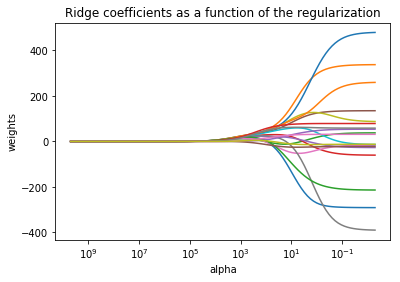

In [102]:
from sklearn.linear_model import Ridge
alphas = 10**np.linspace(10,-2,100)*0.5
ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');